# ĐỀ TÀI: WORD2VEC


## Thực nghiệm 1: biểu diễn văn bản

- TF-IDF
- Word2vec
- Doc2vec


### 1. Tiền xử lý dữ liệu


#### Tải thư viện cần thiết


In [1]:
%pip install pandas
%pip install openpyxl
%pip install scikit-learn
%pip install matplotlib
%pip install gensim
%pip install nltk

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Cài đặt certificates cho macOS (chỉ chạy nếu cần thiết)
import subprocess
import sys
import os

print("Kiểm tra và cài đặt certificates...")

try:
    # Cập nhật certificates
    result = subprocess.run([
        sys.executable, "-m", "pip", "install", "--upgrade", "certifi"
    ], capture_output=True, text=True)
    
    if result.returncode == 0:
        print("Certificates đã được cập nhật")
    else:
        print(f"Lỗi cập nhật certificates: {result.stderr}")
        
    # Kiểm tra các script Install Certificates
    python_paths = [
        "/Applications/Python 3.12/Install Certificates.command",
        "/Applications/Python 3.11/Install Certificates.command", 
        "/Applications/Python 3.10/Install Certificates.command",
        "/Applications/Python 3.9/Install Certificates.command"
    ]
    
    for path in python_paths:
        if os.path.exists(path):
            print(f"Tìm thấy script certificates: {path}")
            try:
                subprocess.run([path], check=True)
                print("Đã chạy Install Certificates thành công")
                break
            except Exception as e:
                print(f"Lỗi chạy script: {e}")
    
except Exception as e:
    print(f"Lỗi cài đặt certificates: {e}")

print("Hoàn thành kiểm tra certificates")

Kiểm tra và cài đặt certificates...
Certificates đã được cập nhật
Tìm thấy script certificates: /Applications/Python 3.12/Install Certificates.command
 -- pip install --upgrade certifi
  Using cached certifi-2025.7.14-py3-none-any.whl.metadata (2.4 kB)
Using cached certifi-2025.7.14-py3-none-any.whl (162 kB)
  Attempting uninstall: certifi
    Found existing installation: certifi 2025.4.26
    Uninstalling certifi-2025.4.26:
      Successfully uninstalled certifi-2025.4.26
 -- removing any existing file or link
 -- creating symlink to certifi certificate bundle
 -- setting permissions
 -- update complete
Đã chạy Install Certificates thành công
Hoàn thành kiểm tra certificates


In [3]:
# Tải NLTK data thủ công nếu SSL không hoạt động
import urllib.request
import zipfile
import os

def download_nltk_data():
    """Tải NLTK punkt data thủ công"""
    nltk_data_dir = os.path.expanduser('~/nltk_data/tokenizers')
    os.makedirs(nltk_data_dir, exist_ok=True)
    
    punkt_url = "https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/tokenizers/punkt.zip"
    punkt_path = os.path.join(nltk_data_dir, "punkt.zip")
    
    try:
        print("Đang tải xuống punkt tokenizer từ GitHub...")
        
        # Tạo SSL context không xác thực
        import ssl
        ssl_context = ssl.create_default_context()
        ssl_context.check_hostname = False
        ssl_context.verify_mode = ssl.CERT_NONE
        
        # Tải file
        request = urllib.request.Request(punkt_url)
        with urllib.request.urlopen(request, context=ssl_context) as response:
            with open(punkt_path, 'wb') as f:
                f.write(response.read())
        
        # Giải nén
        with zipfile.ZipFile(punkt_path, 'r') as zip_ref:
            zip_ref.extractall(nltk_data_dir)
        
        # Xóa file zip
        os.remove(punkt_path)
        print("Tải xuống và cài đặt punkt thành công!")
        return True
        
    except Exception as e:
        print(f"Lỗi tải xuống thủ công: {e}")
        return False

# Thử tải nếu cần
try:
    import nltk
    nltk.data.find('tokenizers/punkt')
    print("NLTK punkt đã có sẵn")
except:
    print("Cần tải NLTK punkt...")
    if download_nltk_data():
        print("Đã tải punkt thành công")
    else:
        print("Không thể tải punkt, sẽ dùng tokenizer thay thế")

NLTK punkt đã có sẵn


In [19]:
import pandas as pd
import re
import string
import matplotlib.pyplot as plt
import numpy as np

# Thư viện dùng để biểu diễn dữ liệu
from sklearn.feature_extraction.text import TfidfVectorizer     # TF-IDF
from gensim.models import Word2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

import nltk
from nltk.tokenize import sent_tokenize, word_tokenize

nltk.download('punkt_tab')

# Thư viện cho thuật toán
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestCentroid, KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB   # Naive Bayes cho bài toán phân loại
from sklearn.preprocessing import MinMaxScaler

# Đánh giá mô hình
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/yoliephan/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


#### Đọc dữ liệu


In [22]:
data_path = "Dataset.xlsx"

df = pd.read_excel(data_path, engine="openpyxl")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 504 entries, 0 to 503
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentence  504 non-null    object
 1   label     504 non-null    object
dtypes: object(2)
memory usage: 8.0+ KB


In [23]:
# Đếm số lượng label
print(df['label'].value_counts())

# In mẫu ra vài dòng
for i, row in df.head(2).iterrows():
    print(f"Row {i+1}.")
    print(f"Content: {row['sentence']}")
    print(f"Label: {row['label']}")
    print("=" * 50)

label
giáo dục    101
khoa học    101
sức khỏe    101
thể thao    101
du lịch     100
Name: count, dtype: int64
Row 1.
Content: Giải thưởng World Luxury Hotel Awards 2022 vinh danh 10 khách sạn và resort Việt Nam ở hạng mục sang trọng nhất châu Á.
Label: du lịch
Row 2.
Content: Almanity Hoi An Wellness Resort là cái tên đầu tiên của Việt Nam được Luxury Hotel Awards 2022 nhắc đến và chiến thắng ở hạng mục Khu nghỉ dưỡng chăm sóc sức khỏe sang trọng nhất châu Á.
Label: du lịch


#### Preprocessing

- Bỏ dấu câu
- lower các kí tự


In [24]:
def preprocess(text: str):
    text = re.sub(f"[{string.punctuation}]", " ", text)
    return text.lower()

df["sentence"] = df["sentence"].apply(lambda x: preprocess(x))
df.head(3)

,sentence,label
0,giải thưởng world luxury hotel awards 2022 vin...,du lịch
1,almanity hoi an wellness resort là cái tên đầu...,du lịch
2,khách sạn nằm ngay trung tâm phố cổ hội an tr...,du lịch


### 2. Xây dựng biểu diễn vector


#### 2.1 Tf-idf

- Tạo tập corpus
- Dùng Tf-idf để fit dữ liệu
- Map document ở từng row


In [25]:
sentences = df["sentence"].to_list()
print(f"Number of documents: {len(sentences)}")

tfidf_vectorizer = TfidfVectorizer()
tfidf_vectorizer.fit(sentences)
print(f"Number of words in corpus: {len(tfidf_vectorizer.vocabulary_)}")

df["tf_idf"] = df["sentence"].apply(lambda x: tfidf_vectorizer.transform([x]).toarray()[0])

print(f"Shape of tf_idf vector: {df['tf_idf'][2].shape}")

Number of documents: 504
Number of words in corpus: 3284
Shape of tf_idf vector: (3284,)


#### 2.2 Word2vec


In [26]:
# model = api.load("fasttext-wiki-news-subwords-300")
# model.save("model/fasttext-300.kv")

In [27]:
sentences = df["sentence"].to_list()

# Cách 1: dùng mô hình tự train
sentences = [word_tokenize(s) for s in sentences]
model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4, epochs=50)

#### Các tham số của mô hình
# sentences,        # dữ liệu đầu vào (các câu đã được token hoá)
# vector_size=100,  # kích thước vector biểu diễn từ
# window=5,         # kích thước cửa sổ ngữ cảnh (context window size)
# min_count=1,      # số lần xuất hiện tối thiểu của một từ để được đưa vào mô hình
# workers=4,        # số luồng xử lý song song
# epochs=50         # số lần lặp qua toàn bộ dữ liệu (huấn luyện)


# # Cách 2: dùng mô hình load sẵn, có thể dùng mô hình pretrain thêm
# try:
#     model = KeyedVectors.load("model/glove_100.kv")
#     print(f"Load model từ thư mục local")
# except:
#     print(f"Mô hình chưa tồn tại, tải mô hình về")
#     model = api.load("glove-wiki-gigaword-100")
#     model.save("model/glove_100.kv")

# Hàm vector hoá
def sentence_to_vec(sent):
    return np.mean([model.wv[w] for w in word_tokenize(sent)], axis=0)

df["word_vector"] = df["sentence"].apply(sentence_to_vec)

df.head()

,sentence,label,tf_idf,word_vector
0,giải thưởng world luxury hotel awards 2022 vin...,du lịch,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-1.0732172, 0.101946495, 0.076508924, 0.50536..."
1,almanity hoi an wellness resort là cái tên đầu...,du lịch,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.81433755, 0.32077318, 0.14580259, 0.143043..."
2,khách sạn nằm ngay trung tâm phố cổ hội an tr...,du lịch,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.5242854, 0.20868973, 0.32137808, -0.480519..."
3,xung quanh khách sạn là các hồ bơi nước mặn và...,du lịch,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.63287824, 0.14204232, 0.44818187, 0.081091..."
4,tại đây du khách vừa có thể nghỉ dưỡng vừa t...,du lịch,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.85032576, -0.10148694, 0.08460633, 0.38938..."


#### 2.3 Doc2vec


In [28]:
sentences = [
    TaggedDocument(words=word_tokenize(row['sentence'].lower()), tags=[str(i)])
    for i, row in df.iterrows()
]

model = Doc2Vec(
    sentences,
    vector_size=100,     # dimension of output vector
    window=5,            # context window size
    min_count=1,         # ignore words with total frequency < 1
    workers=4,           # number of threads
    epochs=50            # number of training iterations
)

# Hàm vector hoá
def sentence_to_vec(sent):
    return model.infer_vector(word_tokenize(sent))

df["doc_vector"] = df["sentence"].apply(sentence_to_vec)

df.head()

,sentence,label,tf_idf,word_vector,doc_vector
0,giải thưởng world luxury hotel awards 2022 vin...,du lịch,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-1.0732172, 0.101946495, 0.076508924, 0.50536...","[-0.23396233, 0.5150588, 0.08551325, -0.263690..."
1,almanity hoi an wellness resort là cái tên đầu...,du lịch,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.81433755, 0.32077318, 0.14580259, 0.143043...","[-0.58173597, 1.0631275, -0.1472317, -0.338048..."
2,khách sạn nằm ngay trung tâm phố cổ hội an tr...,du lịch,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.5242854, 0.20868973, 0.32137808, -0.480519...","[0.081404015, 0.51594144, 0.1769692, -0.594099..."
3,xung quanh khách sạn là các hồ bơi nước mặn và...,du lịch,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.63287824, 0.14204232, 0.44818187, 0.081091...","[-0.60872436, 0.32902488, 0.5986293, -0.048106..."
4,tại đây du khách vừa có thể nghỉ dưỡng vừa t...,du lịch,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.85032576, -0.10148694, 0.08460633, 0.38938...","[-0.4183375, 0.23315348, 0.17600526, 0.1505037..."


### 3. Cài đặt thuật toán phân lớp

- Rocchio
- K-nearest neighbor
- Naive Bayes


#### 3.1 Tạo bộ train & test

- stratify theo label để đảm bảo dữ liệu cân bằng


In [29]:
tfidf_features = df['tf_idf'].to_list()
word2vec_features = df['word_vector'].to_list()
doc2vec_features = df['doc_vector'].to_list()

labels = df['label'].to_list()
X_tfidf_train, X_tfidf_test, X_word2vec_train, X_word2vec_test, X_doc2vec_train, X_doc2vec_test, y_train, y_test = train_test_split(
        tfidf_features, word2vec_features, doc2vec_features, labels, test_size=0.2, random_state=2025, shuffle=True, stratify=labels
    )

len(X_tfidf_train), len(X_tfidf_test), len(X_word2vec_train), len(X_word2vec_test), len(X_doc2vec_train), len(X_doc2vec_test), len(y_train), len(y_test)

(403, 101, 403, 101, 403, 101, 403, 101)

#### 3.2 Fit mô hình

- Feature: TF-IDF, Word2vec, Doc2vec
- Algorithm: Rocchio, K-nearest, Naive Bayes


In [30]:
# TF-IDF
tfidf_rocchio_classifier = NearestCentroid()
tfidf_rocchio_classifier.fit(X_tfidf_train, y_train)

tfidf_knearest_classifier = KNeighborsClassifier(n_neighbors=10)
tfidf_knearest_classifier.fit(X_tfidf_train, y_train)

tfidf_nb_classifier = GaussianNB()
tfidf_nb_classifier.fit(X_tfidf_train, y_train)

# Word2vec
word2vec_rocchio_classifier = NearestCentroid()
word2vec_rocchio_classifier.fit(X_word2vec_train, y_train)

word2vec_knearest_classifier = KNeighborsClassifier(n_neighbors=10)
word2vec_knearest_classifier.fit(X_word2vec_train, y_train)

word2vec_nb_classifier = GaussianNB()
word2vec_nb_classifier.fit(X_word2vec_train, y_train)

# Doc2vec
doc2vec_rocchio_classifier = NearestCentroid()
doc2vec_rocchio_classifier.fit(X_doc2vec_train, y_train)

doc2vec_knearest_classifier = KNeighborsClassifier(n_neighbors=10)
doc2vec_knearest_classifier.fit(X_doc2vec_train, y_train)

doc2vec_nb_classifier = GaussianNB()
doc2vec_nb_classifier.fit(X_doc2vec_train, y_train)

/Users/yoliephan/Desktop/Doan_khaithactt_Nhom8/.venv/lib/python3.12/site-packages/sklearn/neighbors/_nearest_centroid.py:244: UserWarning: self.within_class_std_dev_ has at least 1 zero standard deviation.Inputs within the same classes for at least 1 feature are identical.
  warnings.warn(


,priors,None
,var_smoothing,1e-09


### 4. Đánh giá mô hình


#### Tf-idf


In [31]:
def evaluate(model, X_test, y_test, feature, algorithm, display_labels = df["label"].unique(), average = 'micro'):
    y_pred = model.predict(X_test)

    f1 = recall_score(y_test, y_pred, average=average)
    precision = recall_score(y_test, y_pred, average=average)
    recall = recall_score(y_test, y_pred, average=average)
    cm = confusion_matrix(y_test, y_pred)

    print("=" * 60)
    print(f"Evaluation for model with feature {feature} & algorithm {algorithm}")
    print("=" * 60)

    print(f"f1: {f1}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)

    # Plot the confusion matrix
    disp.plot()

    # Optional: Customize the plot
    disp.ax_.set_title(f"{feature} - {algorithm}")
    plt.show()

#### Tf-idf


Evaluation for model with feature TF-IDF & algorithm Rocchio
f1: 0.9603960396039604
Precision: 0.9603960396039604
Recall: 0.9603960396039604


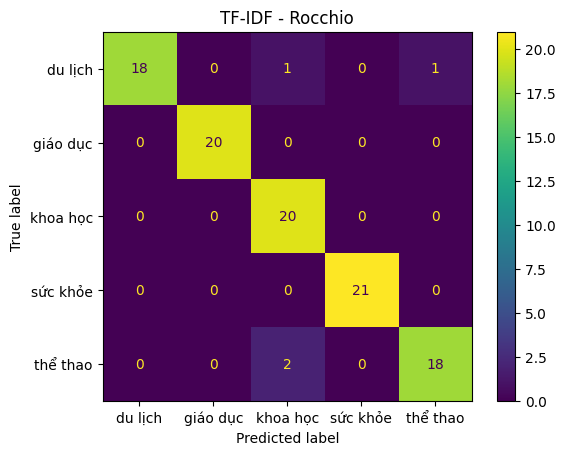

Evaluation for model with feature TF-IDF & algorithm K-nearest
f1: 0.9504950495049505
Precision: 0.9504950495049505
Recall: 0.9504950495049505


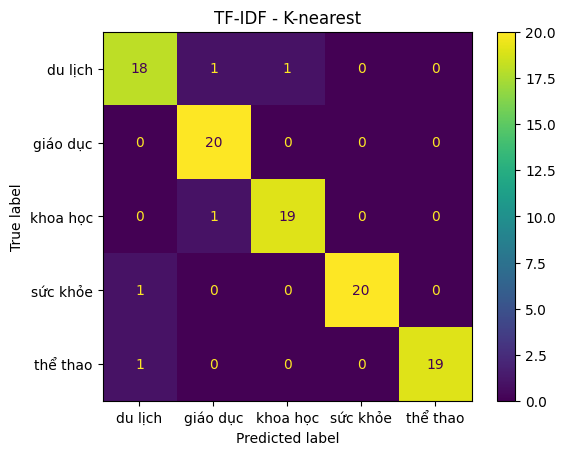

Evaluation for model with feature TF-IDF & algorithm Naive Bayes
f1: 0.8613861386138614
Precision: 0.8613861386138614
Recall: 0.8613861386138614


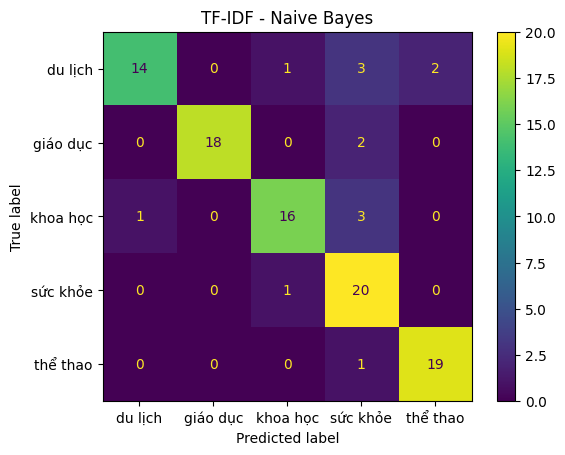

In [32]:
evaluate(tfidf_rocchio_classifier, X_tfidf_test, y_test, "TF-IDF", "Rocchio")
evaluate(tfidf_knearest_classifier, X_tfidf_test, y_test, "TF-IDF", "K-nearest")
evaluate(tfidf_nb_classifier, X_tfidf_test, y_test, "TF-IDF", "Naive Bayes")

#### Word2vec


Evaluation for model with feature Word2vec & algorithm Rocchio
f1: 0.8316831683168316
Precision: 0.8316831683168316
Recall: 0.8316831683168316


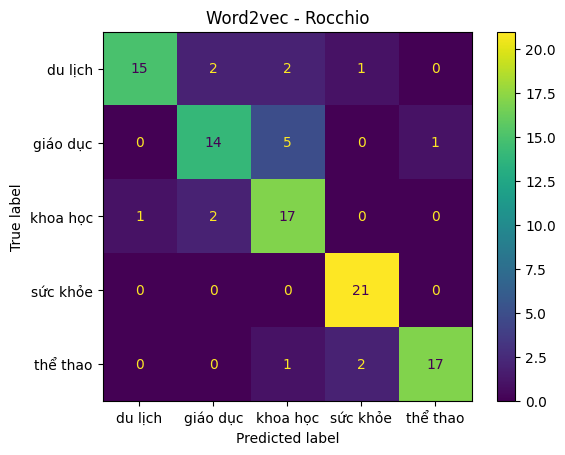

Evaluation for model with feature Word2vec & algorithm K-nearest
f1: 0.8811881188118812
Precision: 0.8811881188118812
Recall: 0.8811881188118812


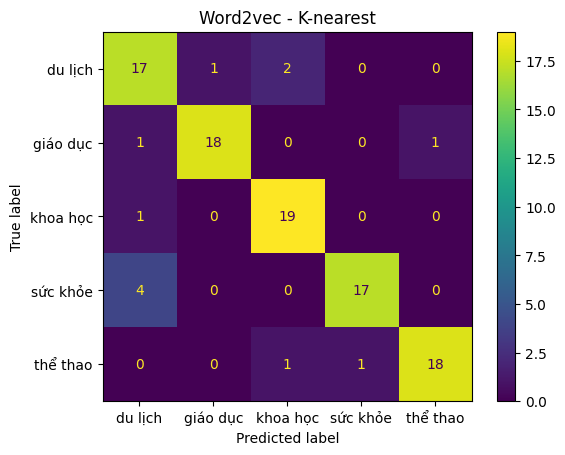

Evaluation for model with feature Word2vec & algorithm Naive Bayes
f1: 0.8514851485148515
Precision: 0.8514851485148515
Recall: 0.8514851485148515


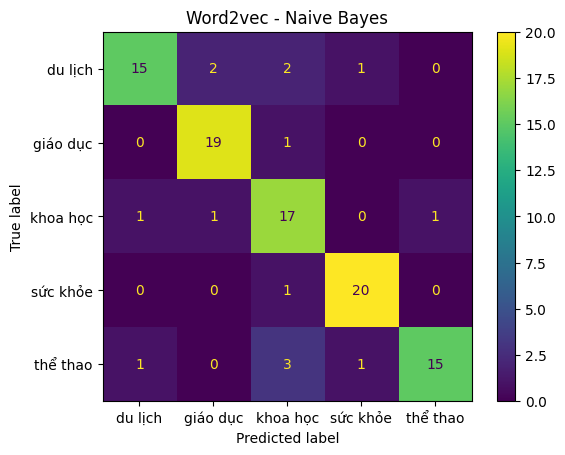

In [17]:
evaluate(word2vec_rocchio_classifier, X_word2vec_test, y_test, "Word2vec", "Rocchio")
evaluate(word2vec_knearest_classifier, X_word2vec_test, y_test, "Word2vec", "K-nearest")
evaluate(word2vec_nb_classifier, X_word2vec_test, y_test, "Word2vec", "Naive Bayes")

#### Doc2vec


Evaluation for model with feature Doc2vec & algorithm Rocchio
f1: 0.6831683168316832
Precision: 0.6831683168316832
Recall: 0.6831683168316832


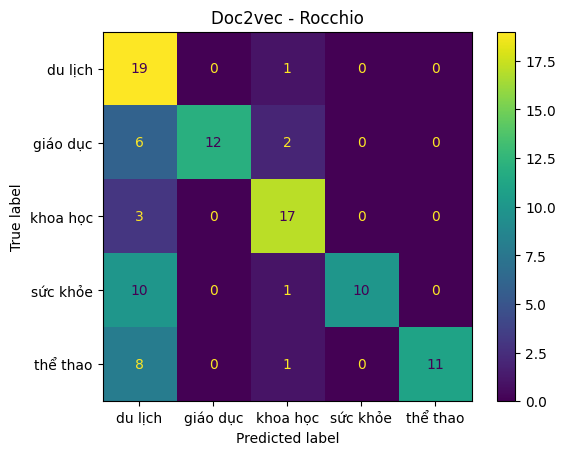

Evaluation for model with feature Doc2vec & algorithm K-nearest
f1: 0.5445544554455446
Precision: 0.5445544554455446
Recall: 0.5445544554455446


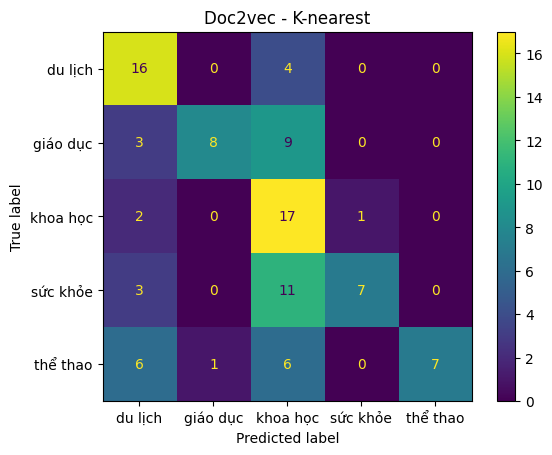

Evaluation for model with feature Doc2vec & algorithm Naive Bayes
f1: 0.3465346534653465
Precision: 0.3465346534653465
Recall: 0.3465346534653465


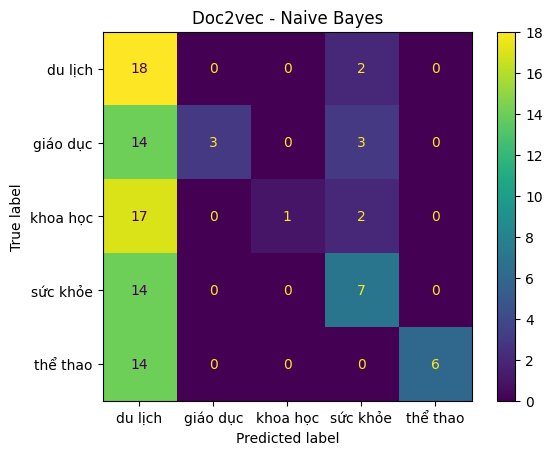

In [18]:
evaluate(doc2vec_rocchio_classifier, X_doc2vec_test, y_test, "Doc2vec", "Rocchio")
evaluate(doc2vec_knearest_classifier, X_doc2vec_test, y_test, "Doc2vec", "K-nearest")
evaluate(doc2vec_nb_classifier, X_doc2vec_test, y_test, "Doc2vec", "Naive Bayes")

#### Đánh giá kết quả

- Mô hình đự đoán với 5 class

- Mô hình **TF-IDF** hoạt động tốt hơn **Word2vec**, tốt hơn **Doc2vec**

- Nguyên nhân:

  - Mô hình **Word2vec** và **Doc2vec** tự train trên tập dữ liệu đang xét, có số lượng khác ít ỏi
  - Mô hình **Word2vec** lấy trung bình cộng vector các từ nên không lấy được ngữ cảnh
  - Mô hình **Doc2vec** hoạt động trên cả bộ dữ liệu nên đòi hỏi số lượng tài liệu để train đặc biệt nhiều để đạt hiệu quả, trong khi bộ dữ liệu đang xét chỉ gồm ~500 từ

- Cải tiến
  - Dữ liệu cần nhiều hơn (craw dữ liệu nhiều hơn cho các class)
